## **Adrenal Tumor Detection and Segmentation with GA-U-KAN**   

### **1 - Image Format Conversion and Visualization**

- 0.0 Download Abdominal CT scans of kidneys with adrenal lesions with corresponding segmentation labels from the NIH Cancer Imaging Archive https://www.cancerimagingarchive.net/collection/adrenal-acc-ki67-seg/

- 1.0 Load the metadata of the orginal CT scans of kidneys with adrenal lesions, `../DICOM_Files/metadata.csv`

- 1.1 Convert all .DICOM stacks downloaded from NIH Cancer Imaging Archive into .NIfTI format in `../NIFTI_Files/..` for future use

- 1.2 Visualize the `Adrenal_Ki67_Seg_001` CT scan sample and its segmentation result

### **2 - Data Split**

- 2.1 Data preprocess, save images of the original scans and their corresponding masks in array form into `images` and `masks` 

- 2.2 Split the porcessed data into `train_input`, `train_label`, `test_input`, and `test_label`

### **3 - Finding the Best-performing U-KAN Model Structure** ***(This Notebook)***

- 3.1 Define operators used to implement the genetic algorithm (GA), include `Selection`, `Crossover`, `Mutation`

- 3.2 Construct the U-Net model (encoder, bottleneck, decoder) with Kolmogorov-Arnold Network Layers

- 3.3 Define the model loss function `model_loss` = `ce_loss` + `dice_loss` + `regularization_loss`

- 3.4 Use `PatchEmbed` to segment input (training/validation) images into patches and find the best U-KAN model

### **4 - (Next Notebook)**

In [2]:
# !pip install opencv-python

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import scipy.misc
from glob import glob
import tqdm
import cv2

import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm
from timm.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
from pdb import set_trace as st

In [5]:
torch.autograd.set_detect_anomaly(True)

## **3.0 - Build the Dataset for Model Training and Testing**

In [7]:
dataset_savingpath = r'C:\Users\amp87\Desktop\ATD_Dataset.pth'

loaded_dataset = torch.load(dataset_savingpath)

train_img = loaded_dataset['train_input']; train_seg = loaded_dataset['train_label']
testvali_img = loaded_dataset['test_input']; testvali_seg = loaded_dataset['test_label']

# training: validation: testing = 70:15:15 

# split the validation and testing sets; just cut into half as train_test_split did randomly split the data
midpoint = len(testvali_img) // 2

vali_img = testvali_img[:midpoint]; test_img = testvali_img[midpoint:]
vali_seg = testvali_seg[:midpoint]; test_seg = testvali_seg[midpoint:]

# set the correct dtype and device for further training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

train_img = train_img.to(device); train_seg = train_seg.to(device)
test_img = test_img.to(device); test_seg = test_seg.to(device)

In [8]:
train_img.shape

torch.Size([5730, 512, 512])

In [9]:
try_train_img = train_img[:30,:,:]; try_vali_img = vali_img[:8,:,:]; try_test_img = test_img[:8,:,:]
try_train_seg = train_seg[:30,:,:]; try_vali_seg = vali_seg[:8,:,:]; try_test_seg = test_seg[:8,:,:]

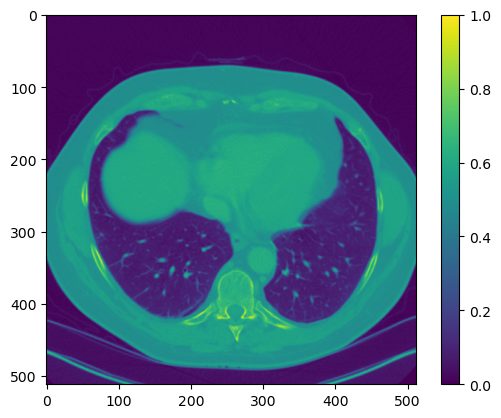

In [10]:
single_image = test_img[250]
image_np = single_image.cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
plt.imshow(image_np)
plt.colorbar()
plt.show()

In [11]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label

In [12]:
# create the training, validation, and test dataset
try_train_dataset = CustomDataset(try_train_img, try_train_seg)
try_vali_dataset = CustomDataset(try_vali_img, try_vali_seg)
try_test_dataset = CustomDataset(try_test_img, try_test_seg)

## **3.1 - Genetic Algorithm**

**3.1.1 GA Parameters**: defines the population

**3.1.2 Fitness Function**: evaluates each chromosome's performance corresponding to each specific U-KAN model

**3.1.3 GA Operators**: defines how the population evolve: Roulette Wheel Selection, Multi-point Cross Over, Random Mutation

### 3.1.1 **GA Parameters and The Initial Population**

***Chromosome Structure:***

| `n_filters` | `filter_size` | `n_control_points` | `spline_order` | `kan_noise` | `kan_input_trans` | `kan_basis_trans` | `kan_regularize_w_scale` | `kan_regularize_entropy_scale` | **Conv_Block** | **Conv_Block** | **Conv_Block** | ...

Each **Conv_Block** has the following inner structure:

| `n_Conv_layers` | `pooling_type` | `batch_normalization_indicator` | `dropout_rate` |

In [16]:
import torch
import numpy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from imblearn.metrics import geometric_mean_score
import seaborn as sns

# losses and accuracies for each generation
losses = []
accuracies = []

In [17]:
# length of each chromosome's non-Cov_Block part
chromo_length = 9

# size of the population
population_size = 20

# param for the crossover and mutation operators
cross_rate = 0.25
mutation_rate = 0.15

# number of generations
n_generations = 500

In [18]:
# create the initial population
population = []

def random_val(starting_val, ending_val, simple_func): # helping func
    # random digit from [starting_val, ending_val-1]
    randi = np.random.randint(starting_val, ending_val)
    out_val = simple_func(randi)
    return out_val

for i in range(population_size):
    chromosome = []
    for j in range(chromo_length):
        if j==0: # initial number of filters, n_filters (4, 8, 16, 32, 64)
            chromosome.append(random_val(2,7, lambda x: 2**x))
        elif j==1: # filter_size (3x3, 5x5, 7x7, 9x9)
            chromosome.append(random_val(1,5, lambda x: 2*x+1))
        elif j==2: # n_control_points (4,5,6,7)
            chromosome.append(random_val(4,8, lambda x: x))
        elif j==3: # spline_order (2,3,4)
            chromosome.append(random_val(2,5, lambda x: x))
        elif j==4: # kan_noise (0.0, 0.1, 0.2)
            chromosome.append(round(random_val(0,3, lambda x: 0.1*x),3))
        elif (j>=5 and j<=8): # input_trans, basis_trans, regularization scales (0.8, 0.9, 1.0, 1.1, 1.2)
            chromosome.append(round(random_val(8,13, lambda x: 0.1*x),3))
    
    # conv blocks
    n_conv_blocks = random_val(2,5, lambda x: x)
    
    for _ in range(n_conv_blocks):
        for k in range(4):
            if k==0: # n_Conv_layers (2,3,4,5)
                chromosome.append(random_val(2,6, lambda x: x))
            if k==1: # pooling_type (0,1)
                chromosome.append(random_val(0,2, lambda x: x))
            elif k==2: # batch_normalization_indicator (0,1)
                chromosome.append(random_val(0,2, lambda x: x))
            elif k==3: # dropout_rate (0.0, 0.1, 0.2, 0.3, 0.4)
                chromosome.append(round(random_val(0,5, lambda x: 0.1*x),3))
            
    population.append(chromosome)

In [19]:
print(' '.join(map(str, population[0])))

16 7 4 4 0.0 1.2 1.2 0.8 0.9 3 1 1 0.3 5 1 1 0.4


### 3.1.2 **Fitness Function `fitness_func`**

In [21]:
# auxiliary functions
def list_flatten(in_list):
    out_list = []
    for item in in_list:
        if isinstance(item, list):
            out_list.extend(list_flatten(item))
        else:
            out_list.append(item)
    return out_list

# Dice coefficient: a set-based similarity measure used to measure how similar two samples are
def dice_coef(seg_true, seg_pred):
    # avoid dividing by 0
    smooth = 1.0
    seg_true_f = list_flatten(seg_true)
    seg_pred_f = list_flatten(seg_pred)
    intersection = np.sum(seg_true_f * seg_pred_f)
    return (2.*intersection + smooth) / (np.sum(seg_true_f) + np.sum(seg_pred_f) + smooth)


def param_count(in_model):
    count = 0
    for param in in_model.parameters():
        count = count + param.view(-1).size()[0]
    return count


def fitness_func(in_chromosome):
    # transform into the corresponding U-Net model
    # train the model using the training set and validate using the validation set
    # record the model's dice coefficient, dice loss, and number of parameters to create a model loss
    # return the chromosome's fitness = 1/model_loss

    # decode chromosome into U-Net architecture with KAN blocks
    model = build_unet_with_kan(in_chromosome) 
    
    # train the model on the training set
    train_loss = train_model(model, train_img, train_seg)
    
    # validate on validation set
    val_dice = validate_model(model, vali_img, vali_seg)
    
    # calculate the fitness value (higher is better)
    chromo_fitness = val_dice / (1 + train_loss)  # Example: balancing between dice score and training loss

    return chromo_fitness

### 3.1.3 **Operators: Create a New, Evolved Population of Chromosomes**



**Selection**: Roulette Wheel Selection

In [24]:
# Roulette Wheel Selection: Chromosomes with higher fitness values are more likely to be selected
def select(current_population, popu_fitness):
    candidate_indices = np.arange(population_size)
    selected_chromo_index = np.random.choice(candidate_indices, size=population_size, replace=True, p=popu_fitness/popu_fitness.sum())
    return current_population[selected_chromo_index]             

**Cross-over**: Multi-point Cross Over

`chromo_length` is the length of each chromosome without the Conv_Blocks part

In [26]:
# Multi-point Cross Over: Two chromosomes, multiple points of intersections (gene swaps)
def cross_over(selected_chromo1, selected_chromo2):
    # random chance of cross over
    if np.random.rand() < cross_rate:
        # list indicating position(s) where gene swap(s) between the given chromosomes happen(s)
        crossing_points = np.random.randint(0,2,size=chromo_length).astype(bool)
        
        child_chromo1 = []
        child_chromo2 = []
        # if True, then cross
        for i, ind in enumerate(crossing_points):
            if ind == True:
                child_chromo1.append(selected_chromo2[i])
                child_chromo2.append(selected_chromo1[i])
            else:
                child_chromo1.append(selected_chromo1[i])
                child_chromo2.append(selected_chromo2[i])

        # for the conv blocks part, cross the intersected part and directly append the longer tail to the corresponding child
        if len(selected_chromo1) <= len(selected_chromo2):
            for j in range(chromo_length,len(selected_chromo1)):
                crossing_ind = np.random.randint(0,2,size=1).astype(bool)
                if crossing_ind == True:
                    child_chromo1.append(selected_chromo2[j])
                    child_chromo2.append(selected_chromo1[j])
                else:
                    child_chromo1.append(selected_chromo1[j])
                    child_chromo2.append(selected_chromo2[j])

            child_chromo2 = child_chromo2 + selected_chromo2[len(selected_chromo1):]

        else:
            for j in range(chromo_length,len(selected_chromo2)):
                crossing_ind = np.random.randint(0,2,size=1).astype(bool)
                if crossing_ind == True:
                    child_chromo1.append(selected_chromo2[j])
                    child_chromo2.append(selected_chromo1[j])
                else:
                    child_chromo1.append(selected_chromo1[j])
                    child_chromo2.append(selected_chromo2[j])

            child_chromo1 = child_chromo1 + selected_chromo1[len(selected_chromo2):]            
                
        return child_chromo1, child_chromo2
                
    # the parents will not be crossed, keep the parent chromosomes
    return selected_chromo1, selected_chromo2 

**Mutation**: Random Mutation

In [28]:
# Random Mutation: Each gene has p=mutation_rate probability to be mutated
def mutated_val(starting_val, ending_val, simple_func, original_val): # helping func
    randi = np.random.randint(starting_val, ending_val)
    out_val = simple_func(randi)
    while abs(out_val-original_val) <= 0.0001: # may have computation errors like 0.00001
        randi = np.random.randint(starting_val, ending_val)
        out_val = simple_func(randi)
    return out_val

def mutate(in_chromo):
    out_chromo = in_chromo.copy()
    for i in range(chromo_length):
        if np.random.rand() <= mutation_rate:
            if i==0: # initial number of filters, n_filters (4, 8, 16, 32, 64)
                out_chromo[i] = mutated_val(2,7, lambda x: 2**x, in_chromo[i])
            elif i==1: # filter_size (3x3，5x5，7x7，9x9)
                out_chromo[i] = mutated_val(1,5, lambda x: 2*x+1, in_chromo[i])
            elif i==2: # n_control_points (4, 5, 6, 7)
                out_chromo[i] = mutated_val(4,8, lambda x: x, in_chromo[i])
            elif i==3: # spline_order (2, 3, 4)
                out_chromo[i] = mutated_val(2,5, lambda x: x, in_chromo[i])
            elif i==4: # kan_noise (0.0, 0.1, 0.2)
                out_chromo[i] = round(mutated_val(0,3, lambda x: 0.1*x, in_chromo[i]),3)
            elif i>=5 and i<=8: # input_trans, basis_trans, regularization scales
                out_chromo[i] = round(mutated_val(8,13, lambda x: 0.1*x, in_chromo[i]),3)

    for j in range(chromo_length, len(in_chromo)):
        if np.random.rand() < mutation_rate:
            if (j-chromo_length)%4 == 0: # n_conv_layers (2, 3, 4, 5)
                out_chromo[j] = mutated_val(2,6, lambda x: x, in_chromo[j])
            elif (j-chromo_length)%4 == 1: # pooling (max/avg)
                out_chromo[j] = 1 - in_chromo[j] # binary
            elif (j-chromo_length)%4 == 2: # batch normalization (activate/inactivate)
                out_chromo[j] = 1 - in_chromo[j] # binary
            elif (j-chromo_length)%4 == 3: # dropout_rate (0.0, 0.1, 0.2, 0.3, 0.4)
                out_chromo[j] = round(mutated_val(0,5, lambda x: 0.1*x, in_chromo[j]),3)

    return out_chromo

See how the Crossover and Mutation Operators Work

In [30]:
print(' '.join(map(str, population[0])))

16 7 4 4 0.0 1.2 1.2 0.8 0.9 3 1 1 0.3 5 1 1 0.4


In [31]:
print(' '.join(map(str, population[1])))

32 5 4 2 0.2 1.2 0.8 1.1 1.0 3 1 0 0.4 4 0 1 0.3 4 1 1 0.2 2 0 1 0.3


In [32]:
example_child_1, example_child_2 = cross_over(population[0], population[1])

print(' '.join(map(str, example_child_1)))
print(' '.join(map(str, example_child_2)))

16 7 4 2 0.2 1.2 1.2 1.1 0.9 3 1 0 0.4 5 1 1 0.4
32 5 4 4 0.0 1.2 0.8 0.8 1.0 3 1 1 0.3 4 0 1 0.3 4 1 1 0.2 2 0 1 0.3


In [33]:
example_mutated_chromo = mutate(population[0])
print(' '.join(map(str, example_mutated_chromo)))

16 5 4 4 0.0 1.2 1.2 0.8 0.9 3 0 1 0.3 5 1 1 0.4


## **3.2 - Build the U-KAN Model**

**3.2.1 Encoder**: Convolutional blocks, built with `Conv_Layers` to extract image features

**3.2.2 Bottleneck**: KAN blocks, built with `KAN_Layers`

**3.2.3 Decoder**: Convolutional blocks, built with `DEC_Conv_Layers` to restore spatial resolution of feature maps, and return the segmentation result

**Receives An Input Chromosome and Decodes it to Build a Chomo-specific U-KAN Model**

### 3.2.1 **Encoder Convolutional Blocks** (Downsampling: Average/Max Pooling Included)

`n_filters` will be doubled after each pooling (either `AvgPool2d()` or `MaxPool2d()`) layer to capture more information when the spatial resolution gets reduced.

In [38]:
# using params from a DECODED chromosome to create a single Convolution Block of n_convolutional_layers
class Conv_Block(torch.nn.Module):
    def __init__(self, n_in, n_conv_layers, n_filters, filter_size, pooling_type, batch_norma_indicator, dropout_rate):
        super(Conv_Block, self).__init__()
        
        # convolutional layers
        self.conv_layers = torch.nn.Sequential()
        # adding modules (conv1, relu1, (bn1,) conv2, relu2, ...) to nn.Sequential()
        for i in range(n_conv_layers):
            conv_layer = torch.nn.Conv2d(n_in if i==0 else n_filters, n_filters, 
                                         kernel_size=filter_size, stride=1, padding='same', bias=True) 

            torch.nn.init.kaiming_normal_(conv_layer.weight, mode='fan_out', nonlinearity='relu') 
            # cannot use kernel_initializer='he_normal' here, humph, pytroch
            
            if conv_layer.bias is not None:
                torch.nn.init.zeros_(conv_layer.bias)

            # convolutional layer
            self.conv_layers.add_module('conv{}'.format(i), conv_layer)

            # activation function
            self.conv_layers.add_module('silu{}'.format(i), torch.nn.SiLU(inplace=True))
            # self.conv_layers.add_module('relu{}'.format(i), torch.nn.ReLU(inplace=True))
            
            # batch normalization
            if batch_norma_indicator==1:
                self.conv_layers.add_module('bn{}'.format(i), torch.nn.BatchNorm2d(n_filters))
            
        # pooling
        if pooling_type==0:
            self.pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling_type==1:
            self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
            
        # dropout
        self.dropout = torch.nn.Dropout(dropout_rate)
            
    def forward(self, X):
        X = self.conv_layers(X)
        X = self.pool(X)
        X = self.dropout(X)
        return X        

### 3.2.2 **Bottleneck LN-DwConv-KAN Blocks**

**Each LN-DwConv-KAN Block Does the Followings in Order**

- **Patch_Embedding**: Reshape input images (${\color[RGB]{220,10,110} \mathbf{X} \in \mathbb{R}^{Channel \times Height \times Width}}$) into $N$ 2D Square Patches of size $P^2$ (${\color[RGB]{220,10,10} \mathbf{X} \in \mathbb{R}^{Channel \times P^2}}$), here $N = \frac{Height \times Width}{P^2}$. In this way, the original two-dimensional image is converted into a one-dimensional sequence that can be easily processed, and map the vectorized patches into a D-dimensional embedding space throgh Linear Projection $\mathbf{E} \in \mathbb{R}^{(Channel \times P^2) \times D}$ to refine feature extraction, $\mathbf{Y} = [\mathbf{X}_1 \mathbf{E}, \mathbf{X}_2 \mathbf{E}, \ldots, \mathbf{X}_N \mathbf{E}]$

- **Feature_Extraction**: Use `KAN_Linear_Calc()` to learn the linear transformation best suited to the task (instead of traditional `ReLU()` Layer), and further extract features using a `Depthwise_Conv_Calc()`, $DwConv(KAN(\mathbf{Y}))$

- **Outcome_Enhancement**: Use Residual Connections to enhance the training performance, $\mathbf{Y} + DwConv(KAN(\mathbf{Y}))$, and then apply Layer Normalization `LayerNormalization()` before returning the output, $Out = LN(\mathbf{Y} + DwConv(KAN(\mathbf{Y})))$

**Output for $\mathcal{k}^{th}$ LN-DwConv-KAN Block**: $Out_{\mathcal{k}} = LN(Out_{\mathcal{k}-1} + DwConv(KAN(Out_{\mathcal{k}-1})))$

#### 3.2.2.1 **Patch_Embedding**

In [44]:
# split input image into patches, which are then mapped to a high-dimensional space
# img_size is an integer (e.g. 256, 32); in_dim is the num of input dims = number of filters at the last encoder layer
class Patch_Embedding(torch.nn.Module):
    def __init__(self, img_size, in_dim, embed_dim, patch_size, stride, padding):
        super(Patch_Embedding, self).__init__()
        # img_size = to_2tuple(img_size)
        # patch_size = to_2tuple(patch_size)

        # patch extraction
        self.patch_size = patch_size
        self.in_dim = in_dim
        self.embed_dim = embed_dim # D different filters

        # N (number of patches) = (((img_size-kernel_size+2*padding)/stride)+1)**2
        # if kernel_size = patch_size = srtide, N = (img_size/patch_size)**2 for square images and patches
        
        # acts the same for cutting an image into patches and embed each 2d patch into D-dimensions
        self.projection = torch.nn.Conv2d(in_dim, embed_dim, kernel_size=patch_size, stride=stride, padding=padding)
        
        self.norm = Layer_Normalization(embed_dim)

    def forward(self, X):
        # split input image into patches
        B, C, H, W = X.size()
        P = self.patch_size
        # X = X.view(B, C, H//P, P, W//P, P)
        # X = X.permute(0,2,4,1,3,5).contiguous() # (B, H//P, W//P, C, P, P)
        # X = X.view(B, -1, C*self.patch_size*self.patch_size) # there are N D-dimensional vectors in each batch

        # patches to N numbers of D-dimensional vector; (the number of patches N = H*W//P²) (the embed_dim D = C*P*P)
        # (batch_size, embed_dim, out_size, out_size) -> (B, D, H*W//P²) -> (B, N, D)
        X = self.projection(X)
        # print('Patch_Embedding Projection Done, Output Shape', X.shape)
        X = X.flatten(2).transpose(1,2)
        X = self.norm(X) 
        
        return X, H//P, W//P # for Dw_Conv layers to process 2d images

#### 3.2.2.2 **Feature_Extraction**: `KAN_Linear_Calc()` and `Depthwise_Conv_Calc()`

In [46]:
from kan import *
from kan.utils import create_dataset

checkpoint directory created: ./model
saving model version 0.0


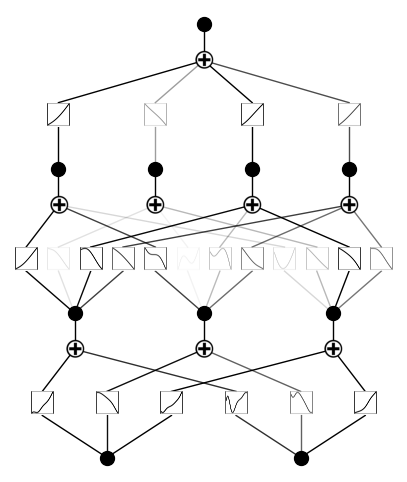

In [47]:
model = KAN(width=[2,3,4,1], grid=4, k=3, seed=42)

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
model(dataset['train_input']);
model.plot()

The exmaple above shows a KAN model structure with `n_in = 2`, `n_hid1 = 3`, `n_hid2 = 4`, `n_out = 1`

Input: $X = [x_1, x_2]$; Output: $f(X) = \Phi_3 \circ \Phi_2 \circ \Phi_1 \circ X$, where $\Phi_3$ is ***(1x4)***, $\Phi_2$ is ***(4x3)***, $\Phi_1$ is ***(3x2)*** and $X$ is ***(2x1)*** 

Each $\Phi$ matirx is consist of ***in x out*** basis functions $\phi$

Each $\Phi$ has the form $ \Phi = \begin{pmatrix} \phi_{1,1}(\cdot) & \phi_{1,2}(\cdot) & \cdots & \phi_{1,n_{\text{in}}}(\cdot) \\ \vdots & \vdots & \vdots & \vdots \\ \phi_{n_{\text{out}},1}(\cdot) & \phi_{n_{\text{out}},2}(\cdot) & \cdots & \phi_{n_{\text{out}},n_{\text{in}}}(\cdot) \end{pmatrix}$; $\,$ For example, $\Phi_1 = \begin{pmatrix} \phi_{1,1}(\cdot) & \phi_{1,2}(\cdot) \\ \phi_{2,1}(\cdot) & \phi_{2,2}(\cdot) \\ \phi_{3,1}(\cdot) & \phi_{3,2}(\cdot) \end{pmatrix} $

Input for `hidden_layer1` = $SiLU(\Phi_1 \circ X) = SiLU \begin{pmatrix} \phi_{1,1}(x_1) + \phi_{1,2}(x_2) \\  \phi_{2,1}(x_1) + \phi_{2,2}(x_2) \\  \phi_{3,1}(x_1) + \phi_{3,2}(x_2) \end{pmatrix} $ where `n_in=2`


Each basis function $\phi(x)$ is an one-variable function with learnable coefficients defined using the Cox-De Boor Recusrion Formula

$\phi(x) =$ $ N_{i,k}(x) = \frac{x - t_i}{t_{i+k} - t_i} N_{i,k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(x)$

Here $t_i$ represents the control point of index $i$

If the number of control points = $m$ such that the list of control points with asending values is $[t_0, t_1, t_2, ..., t_{m-1}]$, then for $i \in \mathbb{N}$ ranging from $0$ to $m-k-1$, there will be a total of $m-k-1$ basis functions for each scalar input

In the following coding blocks, we initialize the grid `self.grid` in the way that the resulting grid is extended on each side by `k` steps to make sure that all inputs have an equal number of non-zero basis functions 



#### 3.2.2.1 **KAN Layer**

**Main Process for Each KAN_Linear_Calc()**

- Input data `X` (**batch_size** x **in_dim**) are sent into the activation function `self.activ_func()` and then the function `self.get_phi_vals()` to get the spline basis functions $\phi(X)$ value (**batch_size** x **in_dim** x **grid_size**). 

- `F.linear()` is then used to perform linear transformation on the unsqueezed $\phi(X)$ tensors (**batch_size** x **in_dim$\ast$grid_size**) with `scaled_phi_trans_weight` (**out_dim** x **in_dim$\ast$grid_size**). Here the `scaled_phi_trans_weight` comes from multiplying the randomly initialized `phi_trans_weight` and the `phi_trans_weight_scaler` together. The `phi_trans_weight_scaler` will only be initialized to random numbers if the passed `standalone_scale_indicator` == `True`, else the scaler will not perform any scaling on `phi_trans_weight`

- The above two steps will generate `b_spline_output` (**batch_size** x **out_dim**) as the layer output

In [55]:
# represents the calculation of Phi∘(Input) for each KAN layer; phi(x) is a one-variable function

# m, k: the number of control points and the order for the spline
# activation_func: allows the input to go through a nonlinear transformation before being linearly transformed
# standalone_scale_indicator: indicates whether each output-input feature pair's spline weight can have its own scaling parameter or not

class KAN_Linear_Calc(torch.nn.Module):
    def __init__(self, n_in_features, n_out_features, m, k, activation_func, noise_controller, 
                 input_trans_scaler, basis_trans_scaler, standalone_scale_indicator):
        super(KAN_Linear_Calc, self).__init__()
        self.in_dim = n_in_features
        self.out_dim = n_out_features
        self.enable_standalone_scale = standalone_scale_indicator
        
        # grid_size = m+2k, each order k of the B-spline reduces the number of effective basis functions by k
        # num_basis_func = (m+2k)-k-1 = m+k-1 (that's why phi_coeff.shape[2] = m+k-1) resulting in m+k-1 non-zero basis functions
        self.grid_size = m+2*k
        self.spline_order = k

        '''
        # construct the initial grid of control points, extended on either side by k steps
        grid = torch.linspace(-1, 1, steps=m)
        n_intervals = grid.shape[0] - 1
        step_length = (grid[-1] - grid[0]) / n_intervals
        for i in range(k):
            grid_extended = torch.concatenate([grid[:1]-step_length, grid], dim=0)
            grid_extended = torch.concatenate([grid_extended, grid_extended[-1:]+step_length], dim=0)
        '''
        
        # construct the initial grid of control points, extended on either side by k steps
        grid = torch.linspace(-1, 1, steps=m)
        
        grid_extended = torch.cat([grid[:1] - (grid[1] - grid[0]) * torch.arange(1, k+1, device=grid.device),
                                   grid,
                                   grid[-1:] + (grid[-1] - grid[-2]) * torch.arange(1, k+1, device=grid.device)])

        # shape will be (in_dim, m+2k)
        self.grid = torch.nn.Parameter(grid_extended.expand(n_in_features, -1).contiguous(), requires_grad=False)
        
        # learnable function coefficients and the transformation weights
        # self.basis_coeff = torch.nn.Parameter(torch.zeros(1, m+k-1, 1), requires_grad=True)

        # activation function used in bas linear transformation
        self.activ_func = activation_func
        
        # base linear transformation weight (out_dim, D) and b-spline transformation weight (out_dim, in_dim, grid_size)
        self.x_trans_weight = torch.nn.Parameter(torch.Tensor(n_out_features, n_in_features), requires_grad=True)
        self.phi_trans_weight = torch.nn.Parameter(torch.Tensor(n_out_features, n_in_features, m+k-1), requires_grad=True)
        
        if standalone_scale_indicator == True:
            # initialize the scaler to scale the phi_trans_weight
            self.phi_trans_weight_scaler = torch.nn.Parameter(torch.Tensor(n_out_features, n_in_features), requires_grad=False) 

        # noise_controller: control the value of the noise added to the coefficients of the basis functions
        self.noise_ctrl = noise_controller

        # a multiplier in `torch.nn.init.kaiming_uniform_()` that is used for adjusting the size of the linear trans weights
        self.x_trans_scaler = input_trans_scaler

        # adjust the initialization scale of the linear trans weight (coefficient of the B-spline basis function*coeff_scaler)
        self.phi_trans_scaler = basis_trans_scaler

        self.set_params()
        self.phi_trans_weight_scaled = self.scaled_phi_trans_weight()
        

    # initialize the weight parameters which to be used in input x's linear transformation 
    def set_params(self):
        torch.nn.init.kaiming_uniform_(self.x_trans_weight, a=math.sqrt(5)*self.x_trans_scaler)
        # set the noise which value is controlled by the noise controller noise_ctrl
        with torch.no_grad():
            noise = (torch.rand(self.grid_size-2*self.spline_order, self.in_dim, self.out_dim)-0.5)*self.noise_ctrl/float(self.grid_size)

            # self.grid.T shape (m, in_dim), noise shape (m, in_dim, out_dim)
            self.phi_trans_weight.data.copy_((self.phi_trans_weight_scaler if not self.enable_standalone_scale else 1.0)
                                             *self.get_func_coeff(self.grid.T[self.spline_order:-self.spline_order], noise))

        if self.enable_standalone_scale:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.phi_trans_weight_scaler, a=math.sqrt(5)*self.phi_trans_scaler)

    # scale the phi_trans_weight
    def scaled_phi_trans_weight(self):
        if self.enable_standalone_scale == True:
            return self.phi_trans_weight*self.phi_trans_weight_scaler.unsqueeze(-1)
        else:
            return 1.0

    
    # receives tensor X, shape: (B*D, N=in_dim)
    # returns the value of basis functions 𝜙(x), shape: (B*N, D=in_dim, m+k-1)
    def get_phi_vals(self, X):
        assert X.dim() == 2 and X.size(1) == self.in_dim
        # grid shape: (D, m+2k)
        grid_ = self.grid # self.grid.unsqueeze(dim=0) 
        
        # X shape: (B*N, D, 1)
        X_ = X.unsqueeze(dim=-1)
        
        # initialize the phi values (the k=0 situation)
        phi_vals = ((X_>=grid_[:,:-1]) & (X_<grid_[:,1:])).to(torch.float) # else will be boolean vals
        
        for k in range(1,self.spline_order+1):
            temp1 = (X_-grid_[:,:-(k+1)])/(grid_[:,k:(-1)]-grid_[:,:-(k+1)])*phi_vals[:,:,:-1]
            temp2 = (grid_[:,(k+1):]-X_)/(grid_[:,(k+1):]-grid_[:,1:(-k)])*phi_vals[:,:,1:]
            phi_vals = temp1 + temp2

        # out phi(X) shape: (B*N, D, m+k-1)
        assert phi_vals.size() == (X.size(0), self.in_dim, self.grid_size-self.spline_order-1)
        return phi_vals.contiguous()
    
    
    # returns the coefficients of a given curve, shape: (out_dim, in_dim, grid_size)
    def get_func_coeff(self, X, Y):
        # input shape: X (batch_size, in_dim), Y (batch_size, in_dim, out_dim)
        assert X.dim() == 2 and X.size(1) == self.in_dim
        assert Y.size() == (X.size(0), self.in_dim, self.out_dim)
        
        # A shape (transposed): (in_dim, m, m+k-1) as the func is only used once in set_params()
        # B shape (transposed): (in_dim, m, out_dim)
        A = self.get_phi_vals(X).transpose(0,1)
        B = Y.transpose(0,1)

        # solving the linear equation AX = B such that sol minimizes abs(Asol-B)
        sol = torch.linalg.lstsq(A,B).solution

        # output shape: (out_dim, in_dim, m+k-1)
        assert sol.permute(2,0,1).size() == (self.out_dim, self.in_dim, self.grid_size-self.spline_order-1)
        return sol.permute(2,0,1).contiguous()

    # =============================================================================================== Initialization ==============

    # ================================================================================ Model Loss and Forward Pass ================
    
    # calculate the regularization loss of the KAN Blocks to reduce the risk of overfitting by penalizing the layers' complexity
    # regula_w_scaler: controls the contribution of the total abs `phi_trans_weight` sum (L1 regularization loss) to the model loss
    # regula_entropy_scaler: scaler which controls the contribution of the Shannon entropy loss to the model loss
    def get_reg_loss(self, reg_w_scaler, reg_entropy_scaler):
        # regularization based on the absolute value of weights
        w_loss = self.phi_trans_weight.abs().mean(-1)
        reg_loss_w = w_loss.sum()
        
        # entropy regularization based on weight distribution
        # calculate the proportion of the average absolute weight value of each output feature to the total absolute weight sum
        prop = w_loss / (reg_loss_w + 1e-8)
        prop = torch.clamp(prop, min=1e-8)
        reg_loss_entropy = -(torch.sum(prop*prop.log())) # Shannon entropy

        return (reg_w_scaler*reg_loss_w + reg_entropy_scaler*reg_loss_entropy)
        
    
    def forward(self, X):
        # input shape: (B*N, D)
        assert X.dim() == 2
        # calculate the value of control points on the basis functions 𝜙(x)
        # the grid is reshaped into (batch_size, height, width, channels)
        # phi_vals = F.grid_sample(X, self.grid.view(-1,1,1,self.grid_size), align_corners=True)
        
        # calculate the Base Linear Transformation 𝑤X; shape (B*N, out_dim)
        activ_x = self.activ_func(X)
        LinearTrans = (F.linear(activ_x, self.x_trans_weight))           # (B*N, D)·(D, out_dim)

        # calculate the B-Spline Transformation 𝑤𝜙(x); shape (B*N, out_dim)
        phi_vals = self.get_phi_vals(X)                                  # phi(X), (B*N, D, m+k-1)
        phi_vals = phi_vals.view(X.size(0),-1)                           # (B*N, D*(m+k-1))
        
        reshaped_phi_trans_weight = self.phi_trans_weight_scaled.view(self.out_dim,-1)
        B_SplineTrans = F.linear(phi_vals, reshaped_phi_trans_weight)    # (B*N, D*(m+k-1))·(D*(m+k-1), out_dim)
        
        return LinearTrans + B_SplineTrans # shape (B*N, out_dim)

#### 3.2.2.2 **Bottleneck_Conv and Depthwise_Conv Layers**

In [57]:
class Bottleneck_Conv_Calc(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Bottleneck_Conv_Calc, self).__init__()
        self.BotConv1 = torch.nn.Conv2d(in_dim, out_dim, kernel_size=3, padding='same') # keep image size the same
        torch.nn.init.kaiming_normal_(self.BotConv1.weight, mode='fan_in', nonlinearity='relu')
        self.BN1 = torch.nn.BatchNorm2d(out_dim)
        self.ReLU1 = torch.nn.ReLU(inplace=True)

        self.BotConv2 = torch.nn.Conv2d(out_dim, out_dim, kernel_size=3, padding='same') 
        torch.nn.init.kaiming_normal_(self.BotConv2.weight, mode='fan_in', nonlinearity='relu')
        self.BN2 = torch.nn.BatchNorm2d(out_dim)
        self.ReLU2 = torch.nn.ReLU(inplace=True)        

    def forward(self, X):
        X = self.BotConv1(X)
        X = self.BN1(X)
        X = self.ReLU1(X)
        X = self.BotConv2(X)
        X = self.BN2(X)
        X = self.ReLU2(X)
        return X

In [58]:
class Depthwise_Conv_Calc(torch.nn.Module):
    def __init__(self, in_dim): # in_dim should be the D for each patch vectors
        super(Depthwise_Conv_Calc, self).__init__()
        # Depthwise Convolution
        self.DwConv = torch.nn.Conv2d(in_dim, in_dim, kernel_size=3, padding='same', bias=False, groups=in_dim)
        torch.nn.init.kaiming_normal_(self.DwConv.weight, mode='fan_in', nonlinearity='relu')
        self.BN = torch.nn.BatchNorm2d(in_dim)
        self.ReLU = torch.nn.ReLU()

        # Pointwise Convolutinon
        # self.PwConv = torch.nn.Conv2d(in_dim, in_dim, kernel_size=1, bias=False)
        # torch.nn.init.kaiming_normal_(self.PwConv.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, X, H_divP, W_divP):
        B, N, D = X.shape
        # (B, N, D), number of patches N = (Height//P) * (Width//P)
        # transform patches from 1d vectors to 2d patch images, so that DwConv() can act on them
        X = X.transpose(1,2).view(B, D, H_divP, W_divP) # number of patches on each side
        X = self.DwConv(X)
        X = self.BN(X)
        X = self.ReLU(X)
        # flatten the patches into 1d vectors again, keep it (B, N, D)
        X = X.flatten(2).transpose(1,2)

        return X

**DwConv-KAN Layers**: works together to extract features

In [60]:
class Feature_Extraction(torch.nn.Module):
    def __init__(self, n_in_features, m, k, activation_func, noise_controller, input_trans_scaler, 
                 basis_trans_scaler, standalone_scale_indicator):
        super(Feature_Extraction, self).__init__()
        
        dropout_rate = 0.0
        
        n_out_features = n_in_features
        self.dim = n_in_features
        self.KAN_Layer1 = KAN_Linear_Calc(n_in_features, n_in_features, m, k, activation_func, noise_controller, 
                                          input_trans_scaler, basis_trans_scaler, standalone_scale_indicator) 
        self.KAN_Layer2 = KAN_Linear_Calc(n_in_features, n_in_features, m, k, activation_func, noise_controller, 
                                          input_trans_scaler, basis_trans_scaler, standalone_scale_indicator) 
        self.KAN_Layer3 = KAN_Linear_Calc(n_in_features, n_in_features, m, k, activation_func, noise_controller, 
                                          input_trans_scaler, basis_trans_scaler, standalone_scale_indicator)
        self.DwConv_Layer1 = Depthwise_Conv_Calc(n_in_features)
        self.DwConv_Layer2 = Depthwise_Conv_Calc(n_in_features)
        self.DwConv_Layer3 = Depthwise_Conv_Calc(n_in_features)

        self.Dropout = torch.nn.Dropout(dropout_rate)

    # evaluate how complex the KAN-Block structure is
    def reg_loss(self, reg_w, reg_etp):
        model_reg_loss = self.KAN_Layer1.get_reg_loss(reg_w, reg_etp) + self.KAN_Layer2.get_reg_loss(reg_w, reg_etp)
        model_reg_loss = model_reg_loss + self.KAN_Layer3.get_reg_loss(reg_w, reg_etp)
        return model_reg_loss


    def forward(self, X, H_divP, W_divP):
        B, N, D = X.shape

        X = self.KAN_Layer1(X.reshape(B*N,D))
        X = X.reshape(B,N,D).contiguous()
        X = self.DwConv_Layer1(X, H_divP, W_divP)
        
        X = self.KAN_Layer2(X.reshape(B*N,D))
        X = X.reshape(B,N,D).contiguous()
        X = self.DwConv_Layer2(X, H_divP, W_divP)
        
        X = self.KAN_Layer3(X.reshape(B*N,D))
        X = X.reshape(B,N,D).contiguous()
        X = self.DwConv_Layer3(X, H_divP, W_divP)
        
        return X    

#### 3.2.2.3 **Outcome_Enhancement**: Residual Connection and `Layer_Normalization()`

In [62]:
class Layer_Normalization(torch.nn.Module):
    def __init__(self, num_features):
        super(Layer_Normalization, self).__init__()
        self.layer_norm = torch.nn.LayerNorm(num_features)
        self.set_init_weights()

    def set_init_weights(self):
        if isinstance(self.layer_norm, torch.nn.LayerNorm):
            torch.nn.init.constant_(self.layer_norm.bias, 0)
            torch.nn.init.constant_(self.layer_norm.weight, 1.0)

    def forward(self, X):
        return self.layer_norm(X)

#### 3.2.2.4 **Single LN-DwConv-KAN Block**

In [64]:
# embedded_dims: list of the dimensions D (e.g. [256(in), 328(kan1), 512(kan2), 328(dkan3), 256(dkan4)])
class LN_DwConv_KAN_Block(torch.nn.Module):
    def __init__(self, embed_dim, num_control_points, order_of_spline, activ_function, noise_control, input_trans_scale, 
                 basis_trans_scale, standalone_indicator, regularize_w_scale, regularize_entropy_scale, drop_path_rate):
        super(LN_DwConv_KAN_Block, self).__init__()

        '''
        self.DwConv_KAN_Layers = torch.nn.ModuleList()
        self.LN_Layers = torch.nn.ModuleList()
        self.Drop_Paths = torch.nn.ModuleList()

        # LN-DwConv-KAN Layer Blocks 
        # e.g. 0,(256,328), 1,(328,512), 2,(512,328), 3,(328,256)
        for i, (in_dim, out_dim) in enumerate(zip(embedded_dims[:-1], embedded_dims[1:])): 
            self.DwConv_KAN_Layers.append(Feature_Extraction(out_dim, num_control_points, order_of_spline, activ_function,
                                                             noise_control, input_trans_scale, basis_trans_scale, standalone_indicator))
            self.LN_Layers.append(Layer_Normalization(out_dim))
            self.Drop_Paths.append(DropPath(drop_path_rates[i]) if drop_path_rates[i] > 0. else torch.nn.Identity())
        '''
        self.DwConv_KAN_Layer = Feature_Extraction(embed_dim, num_control_points, order_of_spline, activ_function,
                                                   noise_control, input_trans_scale, basis_trans_scale, standalone_indicator)
        
        self.LN_Layer = Layer_Normalization(embed_dim)
        
        self.Drop_Paths = DropPath(drop_path_rate) if drop_path_rate>0. else torch.nn.Identity() 

        self.reg_w_scale = regularize_w_scale
        self.reg_entropy_scale = regularize_entropy_scale

    
    # evaluate how complex the KAN-Block structure is
    def regularization_loss(self):
        '''
        regula_loss = torch.tensor(0.0, dtype=torch.float)
        for DwC_KAN_layer in self.DwConv_KAN_Layers:
            regula_loss += DwC_KAN_layer.reg_loss(self.reg_w_scale, self.reg_entropy_scale)
        '''
        regula_loss = self.DwConv_KAN_Layer.reg_loss(self.reg_w_scale, self.reg_entropy_scale)
        return regula_loss
        # return torch.sum(DK_layer.reg_loss(self.reg_w_scale, self.reg_entropy_scale) for DK_layer in self.DwConv_KAN_Layers)


    # see the above description about how it works **Each LN-DwConv-KAN Layer Does the Followings in Order**
    def forward(self, X, H_divP, W_divP):
        '''
        for DwConv_KAN_layer, LN_layer, drop_path in zip(self.DwConv_KAN_Layers, self.LN_Layers, self.Drop_Paths):
            # residual connection
            X = LN_layer(X + drop_path(DwConv_KAN_layer(X, H_divP, W_divP)))
        '''
        out = self.LN_Layer(X + self.Drop_Paths(self.DwConv_KAN_Layer(X, H_divP, W_divP)))
        return out

### 3.2.3 **Decoder Convolutional Blocks** (Upsampling：Bilinear Interpolation Executed Outside the Block)

In [66]:
# similarily, using params from a DECODED chromosomes, but reversely
class Deco_Conv_Block(torch.nn.Module):
    def __init__(self, n_in_filters, n_conv_layers, n_out_dim, filter_size, batch_norma_indicator): #, dropout_rate):
        super(Deco_Conv_Block, self).__init__()
        
        # convolutional layers, n_out_dim is half of n_in_filters
        self.conv_layers = torch.nn.Sequential()
        # adding modules (conv1, relu1, (bn1,) conv2, relu2, ...) to nn.Sequential()
        for i in range(n_conv_layers):
            conv_layer = torch.nn.Conv2d(n_in_filters, n_out_dim if i==n_conv_layers-1 else n_in_filters,
                                         kernel_size=filter_size, stride=1, padding='same', bias=True) 
            torch.nn.init.kaiming_normal_(conv_layer.weight, mode='fan_out', nonlinearity='relu') # cannot use 'he_normal'
            if conv_layer.bias is not None:
                torch.nn.init.zeros_(conv_layer.bias)

            # convolutional layer
            self.conv_layers.add_module('conv{}'.format(i), conv_layer)

            # activation function
            self.conv_layers.add_module('silu{}'.format(i), torch.nn.SiLU(inplace=True))
            # self.conv_layers.add_module('relu{}'.format(i), torch.nn.ReLU(inplace=True))
            
            # batch normalization
            if batch_norma_indicator==1 and i!=n_conv_layers-1 :
                self.conv_layers.add_module('bn{}'.format(i), torch.nn.BatchNorm2d(n_in_filters))
            elif batch_norma_indicator==1 and i==n_conv_layers-1 :
                self.conv_layers.add_module('bn{}'.format(i), torch.nn.BatchNorm2d(n_out_dim))
    
        # dropout
        # self.dropout = torch.nn.Dropout(dropout_rate)
            
    def forward(self, X):
        X = self.conv_layers(X)
        # X = self.dropout(X)
        return X        

**Final_Output_Layer**: output the mask in shape (batch_size, initial_channel, initial_img_height, initial_img_width)

In [68]:
class Final_Output_Calc(torch.nn.Module):
    def __init__(self, n_in_dim, initial_input_channel, num_classes):
        super(Final_Output_Calc, self).__init__()
        self.FinalConv = torch.nn.Conv2d(n_in_dim, initial_input_channel, kernel_size=1)
        self.n_calsses = num_classes

    def forward(self, X):
        X = self.FinalConv(X)

        # sigmoid()/softmax() got banned for using Cross Entropy Loss
        '''
        if self.n_classses == 1:
            X = torch.sigmoid(X) # binary classification (adrenal nodule - presence or not)
        elif self.n_classes > 1:
            X = F.softmax(X, dim=1) # multi-class classification/segmentation task
        else:
            print('Something Suspicious: num_classes < 1?')
        '''
        return X

### 3.2.4 **Build U-KAN Model** According to Each Decoded Chromosome

In [70]:
class UKAN(torch.nn.Module):
    def __init__(self, num_classes, in_channel, img_size, patch_size, drop_path_rate, in_chromosome):
        super(UKAN, self).__init__()

        # unpacking chromosome genes
        # n_filters, filter_size, n_control_pts, spline_order, kan_noise, kan_input_trans_scale = in_chromosome[:chromo_length-3]
        # kan_basis_trans_scale, kan_regularize_w_scale, kan_regularize_entropy_scale = in_chromosome[chromo_length-3:chromo_length]

        blocks_info = [] # store the encoder block info [[2, 0, 0, 0.2], [5, 0, 0, 0.2], [5, 0, 1, 0.4]]
        block_info = []
        n_blocks = 1
        for i in range(chromo_length,len(in_chromosome)):
            if i%4 == 1:
                if block_info!=[]:
                    blocks_info.append(block_info)
                block_info = []
                block_info.append(in_chromosome[i])
                n_blocks = n_blocks + 1
            else:
                block_info.append(in_chromosome[i])
        blocks_info.append(block_info)        

        # and for the decoder blocks
        deco_blocks_info = list(reversed(blocks_info))

        # =================================================================================== Encoder Blocks ======================

        self.Encoder_Blocks = torch.nn.ModuleList()

        # n_filters should be doubled after pooling
        n_filters, filter_size = in_chromosome[0], in_chromosome[1]
        n_block_filters = n_filters//2
        in_dim = in_channel
        
        for block_info in blocks_info:
            n_conv_layers, pooling_type, batch_normalization_indicator, dropout_rate = block_info
            n_block_filters = n_block_filters*2
            self.Encoder_Blocks.append(Conv_Block(in_dim, n_conv_layers, n_block_filters, 
                                                  filter_size, pooling_type, batch_normalization_indicator, dropout_rate))
            in_dim = n_block_filters

        # =================================================================================== Bottleneck Blocks ===================

        # the last number of filters for the last convolutional block for grey image 
        in_dim = n_block_filters
        P = patch_size

        self.Embed_Patches1 = Patch_Embedding(img_size=img_size//(2**n_blocks), 
                                              in_dim=in_dim, embed_dim=in_dim*(P**2), 
                                              patch_size=P, stride=P, padding=0)

        self.Embed_Patches2 = Patch_Embedding(img_size=img_size//(2**n_blocks)//(P**2), 
                                              in_dim=in_dim*(P**2), embed_dim=in_dim*(P**4), 
                                              patch_size=P, stride=P, padding=0)
                                       
        dropout_rates_list = [dpr.item() for dpr in torch.linspace(0, drop_path_rate, 4)]
        self.Bottleneck_Blocks = torch.nn.ModuleList()

        embedded_dims = [in_dim, in_dim*(P**2), in_dim*(P**4), in_dim*(P**2), in_dim]

        # the LDK Blocks (LN_DwConv_KAN Blocks) 
        for i in range(len(embedded_dims)-1):
            self.Bottleneck_Blocks.append(LN_DwConv_KAN_Block(embed_dim=embedded_dims[i+1], 
                                                              num_control_points=in_chromosome[2],   # n_control_pts,
                                                              order_of_spline=in_chromosome[3],      # spline_order, 
                                                              activ_function=torch.nn.GELU(),        # (activation function,)
                                                              noise_control=in_chromosome[4],        # kan_noise,
                                                              input_trans_scale=in_chromosome[5],    # kan_input_trans_scale, 
                                                              basis_trans_scale=in_chromosome[6],    # kan_basis_trans_scale,
                                                              standalone_indicator=True,
                                                              regularize_w_scale=in_chromosome[7],   # kan_regularize_w_scale,
                                                              regularize_entropy_scale=in_chromosome[8], # kan_regularize_entropy_scale,
                                                              drop_path_rate=dropout_rates_list[i]))

        self.Bottleneck_Conv_Layer1 = Bottleneck_Conv_Calc(in_dim*(P**4), in_dim*(P**2))
    
        self.Bottleneck_Conv_Layer2 = Bottleneck_Conv_Calc(in_dim*(P**2), in_dim) # input shape (batch_size, in_dim*P²*P², H/P², W/P²)

        # =================================================================================== Decoder Blocks ======================

        self.Decoder_Blocks = torch.nn.ModuleList()

        # n_filters should be halved after each bilinear operation
        n_deco_block_filters = in_dim*2
        
        for deco_block_info in deco_blocks_info:
            n_conv_layers, _, batch_normalization_indicator, _ = deco_block_info
            n_deco_block_filters = n_deco_block_filters//2
            out_dim = n_deco_block_filters//2
            self.Decoder_Blocks.append(Deco_Conv_Block(n_deco_block_filters, n_conv_layers, out_dim, 
                                                       filter_size, batch_normalization_indicator)) # , dropout_rate))
            

        self.Final_Layer = Final_Output_Calc(out_dim, in_channel, num_classes)
        # self.Softmax_Layer = torch.nn.Softmax(dim=1)

    # ============================================================================================================================
    # ============================================================================================================================
    # ============================================================================================================================

    # calculate the regularization loss to quantifact the LN-DwConv_KAN Blocks' complexity
    def reg_loss(self):
        loss = torch.tensor(0.0, dtype=torch.float)
        for Bottleneck_Block in self.Bottleneck_Blocks:
            loss = loss + Bottleneck_Block.regularization_loss()
        return loss

    # receives the input image and go through the u-kan-net 
    def forward(self, X):
        # store intermediate features for skip connections
        Encoder_Outputs = []
        out = X
        B = X.shape[0]

        # =================================================================================== Encoder ============================
            
        for Encoder_Block in self.Encoder_Blocks:
            out = Encoder_Block(out)  # pass through each encoder block
            # print('Encoder Out Shape', out.shape) # print('+++++++++++++++++++++++++++++++++')
            Encoder_Outputs.append(out)  # store output for skip connection

            # out: (B, C, H, W) 
    
        # =================================================================================== Bottleneck =========================

        i = 0
        for LN_DwConv_KAN_Blk in self.Bottleneck_Blocks:
            i = i + 1
            if i == 1:
                out, H_divP, W_divP = self.Embed_Patches1(out)  # (B, N=H*W/P², D=C*P²)
                # print('Patch_Embedding 1 Out Shape', out.shape)
                out = LN_DwConv_KAN_Blk(out, H_divP, W_divP) # output shape (B, N=H*W/P², D=C*P²)
                out = out.reshape(B, H_divP, W_divP, -1).permute(0,3,1,2).contiguous() 
                # print('LDK 1 Out Shape', out.shape) # out: (B, C*P², H/P, W/P) =================================
                ldk_out1 = out
                
            elif i == 2:
                out, H_divP, W_divP = self.Embed_Patches2(out)
                # print('Patch_Embedding 2 Out Shape', out.shape)
                out = LN_DwConv_KAN_Blk(out, H_divP, W_divP)
                out = out.reshape(B, H_divP, W_divP, -1).permute(0,3,1,2).contiguous()
                # print('LDK 2 Out Shape', out.shape) # out: (B, C*P²*P², H/P², W/P²) ============================
                ldk_out2 = out
                
            elif i == 3:
                out = F.relu(F.interpolate(self.Bottleneck_Conv_Layer1(out), scale_factor=(2,2), mode='bilinear'))
                # print('Upsampling 1 Out Shape', out.shape) # out: (B, C*P², H/P, W/P)
                _, N, H_divP, W_divP = out.shape
                out = out.flatten(2).transpose(1,2) # (B, N=H*W/P², D=C*P²)
                out = LN_DwConv_KAN_Blk(out, H_divP, W_divP)
                out = out.reshape(B, H_divP, W_divP, -1).permute(0,3,1,2).contiguous()
                # print('LDK 3 Out Shape', out.shape) # out: (B, C*P², H/P, W/P) =================================
                
            elif i == 4:
                out = torch.add(out, ldk_out1) # skip connection in the bottleneck part
                out = F.relu(F.interpolate(self.Bottleneck_Conv_Layer2(out), scale_factor=(2,2), mode='bilinear'))
                # print('Upsampling 2 Out Shape', out.shape) # out: (B, C, H, W)
                _, N, H_divP, W_divP = out.shape
                out = out.flatten(2).transpose(1,2) # (B, N=H*W, D=C)
                out = LN_DwConv_KAN_Blk(out, H_divP, W_divP)
                out = out.reshape(B, H_divP, W_divP, -1).permute(0,3,1,2).contiguous()
                # print('LDK 4 Out Shape', out.shape) # out: (B, C, H, W) ========================================

            # out: (B, C, H, W) (upsampled)
                
        # =================================================================================== Decoder ============================

        for i, Decoder_Block in enumerate(self.Decoder_Blocks):
            # retrieve corresponding encoder output for skip connection; reverse access to the saved encoder outputs! 
            skip_conn = Encoder_Outputs[len(Encoder_Outputs)-1-i]  
            out = out + skip_conn  # out = torch.cat((out, skip_conn), dim=1)
            out = F.relu(F.interpolate(Decoder_Block(out), scale_factor=(2,2), mode ='bilinear'))
            # print('Decoder Out Shape', out.shape) # print('--------------------------------')

            # out: size of the original input image

        # ========================================================================================================================

        # Final_Output_Layer (classification) and Softmax_Layer (already added in the class) to get probabilities
        out = self.Final_Layer(out)  # Convolution to reduce to num_classes channels # out = self.Softmax_Layer(out)
    
        return out

## **3.3 Use GA to Find the Best U-KAN Model** 

### 3.3.1 **Define the Model Loss = `CE_Loss` + `Dice_Loss` + `Regularization_Loss`**

- **dice coefficient**: a statistical measure of the similarity of two samples which is the common metric for pixel segmentation, $DSC = \frac{2|X \cap Y|}{|X|+|Y|}$
- **dice loss**: convert the dice coefficient into the form of loss function, = 1-dice_coefficient
- **cross-entropy loss**: the loss measuring the performance of a classification model between input logits and target
- **regularization loss**: the loss term penalizing KAN layers' complexity to avoid the risk of overfitting (calculated along with each KAN layer)


Using `Model_Loss` = `CE_Loss` + `DICE_Loss` + `REG_Loss`, the model training is guided by optimizing the similarity between the predicted mask and the real mask while minimizing the model complexity to prevent overfitting

In [73]:
# beta: adjust the weights of True Positive cases (TP) and False Negative (FN) cases in the dice coefficient
# beta = 1 means that the weights of the two are equal

# smooth: small constant, helps avoiding unstable values caused by zero/nearly-zero denominators
def dice_loss(mask_predicted, mask_target, beta=0.0, smooth=1e-5):
    B_pred, C_pred, H_pred, W_pred = mask_predicted.size()
    B_targ, C_targ, H_targ, W_targ = mask_target.size()

    # make sure that the size of the predicted and target masks are the same
    if H_pred!=H_targ or W_pred!=W_targ:
        mask_predicted = F.interpolate(mask_predicted, size=(H_targ,W_targ), mode='bilinear', align_corners=True)

    # apply Softmax() to the pred output and convert it into a probability distribution over classes
    normalized_pred = torch.softmax(mask_predicted, dim=1)

    # flatten into (B, C, H*W)
    normalized_pred = normalized_pred.view(B_pred, C_pred, -1)
    normalized_targ = mask_target.view(B_pred, C_targ, -1)

    TP = torch.sum(normalized_pred*normalized_targ, dim=2) # high value if both are non-zero vals of the same class
    FP = torch.sum(normalized_pred, dim=2) - TP
    FN = torch.sum(normalized_targ, dim=2) - TP

    # (2.0*(normalized_pred*normalized_targ).sum() + smooth)/(normalized_pred.sum() + normalized_targ.sum() + smooth)
    dice_score = ((1+beta**2)*TP + smooth) / ((1+beta**2)*TP + (beta**2)*FN + FP + smooth)
    dice_coeff = torch.mean(dice_score)

    # dice_loss
    return (1-dice_coeff)

### 3.3.2 **Define the Process for Training the U-Net Model with KAN Blocks**

In [75]:
'''
try_train_loader = DataLoader(try_train_dataset, batch_size=10, shuffle=True)
try_vali_loader = DataLoader(try_vali_dataset, batch_size=10, shuffle=False)
try_test_loader = DataLoader(try_test_dataset, batch_size=10, shuffle=False)
'''

training_data_loader = DataLoader(try_train_dataset, batch_size=1, shuffle=True)
for i, (inputs, labels) in enumerate(training_data_loader):
    if i == 0:
        print(inputs.dim()) # need .unsqueeze()

3


In [76]:
def train_ukan_model(ukan_model, batch_size=5, epochs=5, learning_rate=0.00001): # device?
    
    training_data_loader = DataLoader(try_train_dataset, batch_size=batch_size, shuffle=True)

    # Model Loss = CE_Loss + DICE_Loss + REG_Loss
    # ce_loss = torch.nn.CrossEntropyLoss()
    bce_loss = torch.nn.BCEWithLogitsLoss()
    # optimizer = torch.optim.Adam(ukan_model.parameters(), lr=learning_rate)
    optimizer = torch.optim.RMSprop(ukan_model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    
    # ukan_model = ukan_model.to(device)
    
    ukan_model.train()
    # running_loss = 0.0
    for inputs, labels in training_data_loader:
        # inputs, labels = inputs.to(device), labels.to(device)
            
        inputs = inputs.unsqueeze(1) # add the dim1 channel to grayscale image inputs
        labels = labels.unsqueeze(1)

        print(inputs.shape)
        print(labels.shape)

        
        outputs = ukan_model(inputs)
        
        '''
        CE_Loss = bce_loss(outputs, labels)
        print(CE_Loss)
        DICE_Loss = dice_loss(outputs, labels, beta=0.0, smooth=1e-5)
        print(DICE_Loss)
        REG_Loss = ukan_model.reg_loss()/100.0
        print(REG_Loss)
        '''

        loss = bce_loss(outputs, labels)
        # loss = CE_Loss + DICE_Loss + REG_Loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # running_loss = running_loss + loss.item() 
        
        # print(f'Epoch {epoch+1}, Loss: {running_loss/len(training_data_loader)}')

    # torch.save(ukan_model.state_dict(), 'ukan_model.pth')

In [77]:
# build the model and start training
ukan_model = UKAN(num_classes=1, in_channel=1, img_size=512, patch_size=2, drop_path_rate=0.004, in_chromosome=population[1])
train_ukan_model(ukan_model, batch_size=5, epochs=5, learning_rate=0.00001)

torch.Size([5, 1, 512, 512])
torch.Size([5, 1, 512, 512])
torch.Size([5, 1, 512, 512])
torch.Size([5, 1, 512, 512])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
ukan_model

In [ ]:
def validate_model(model, vali_img, vali_seg):
    model.eval()
    with torch.no_grad():
        output = model(vali_img)
        dice_val = dice_coef(vali_seg, output)
    return dice_val

In [ ]:
X_with_channel = X.unsqueeze(1)

# B, C, H, W
print(X_with_channel.shape) 

- knot vector: [$u_0$, $u_1$, $u_2$, ... $u_{m+k}$]  $\,\,$ ($\,$vector length = $m+k+1$)
- $u_0$ = $u_1$ = ... = $u_{k}$ = $0$
- $u_{j+k}$ = $\frac{j}{m-k+2}$ for $j=1,2,...,m-k-1$ $\,\,$ (uniformly spaced knot vector)
- or $u_{j+k}$ = $\frac{1}{k} \sum^{j+k-2}_{i-j} t_i$ for $j=1,2,...,m-k-1$, where $t_i$ is the control point value at index $i$ $\,$ (chord length method for global interpolation)
- $u_{m+1}$ = $u_{m+2}$ = ... = $u_{m+k}$ = $1$

### **Single U-KAN Model's Structure**

